In [1]:
import os
import s3fs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


In [2]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
BUCKET = "ebahri-ensae"
FILE_KEY_S3 = "X_train_Hi5.csv"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    x_train = pd.read_csv(file_in, sep=",")

/tmp/ipykernel_91103/992204584.py:8: DtypeWarning: Columns (108,110,111,115,117,118,122,124,125) have mixed types. Specify dtype option on import or set low_memory=False.
  x_train = pd.read_csv(file_in, sep=",")


In [4]:
x_train.head()

,row_index,piezo_station_department_code,piezo_station_update_date,piezo_station_investigation_depth,piezo_station_department_name,piezo_station_commune_code_insee,piezo_station_pe_label,piezo_station_bdlisa_codes,piezo_station_altitude,piezo_station_bss_code,...,prelev_longitude_2,prelev_latitude_2,prelev_commune_code_insee_2,prelev_other_volume_sum,insee_%_agri,insee_pop_commune,insee_med_living_level,insee_%_ind,insee_%_const,piezo_groundwater_level_category
0,0,01,Sun Jul 14 13:00:02 CEST 2024,20.00,Ain,01073,PIEZOMETRE - MARAIS DE LAVOURS (CEYZERIEU - BR...,['712AH37'],232.00,07004X0046/D6-20,...,5.698947,45.725106,1454.0,1.793055e+09,11.8,992.0,25250,2.9,16.2,High
1,1,01,Sun Jul 14 13:00:02 CEST 2024,35.60,Ain,01363,PIEZOMETRE - GRAVIERE (ST-JEAN-LE-VIEUX - BRGM...,['712GB05'],247.25,06754X0077/F1,...,5.464933,46.210734,1051.0,1.085125e+09,0.6,1786.0,24660,44.5,11,Very High
2,2,01,Sun Jul 14 13:00:02 CEST 2024,35.22,Ain,01244,PIEZOMETRE - BORD AUTOROUTE (MEXIMIEUX - BRGM ...,['040AJ43'],218.77,06993X0226/MEXI_2,...,5.085060,45.812828,69266.0,3.810492e+08,0,8085.0,24890,8.4,7.8,High
3,3,01,Sun Jul 14 13:00:02 CEST 2024,34.20,Ain,01288,PIEZOMETRE - GRENY (PERON - BRGM 01) - BSH,"['516AA00', '516AF00']",499.85,06533X0070/F2,...,5.802841,46.366049,39286.0,3.800911e+08,1.5,2838.0,39700,2.4,5.2,Very High
4,4,01,Sun Jul 14 13:00:02 CEST 2024,37.30,Ain,01422,FORAGE - ENCLOS (TOSSIAT - BRGM 01) - BSH,['507AB00'],260.00,06518X0026/P2,...,5.377265,46.080989,1273.0,1.966631e+07,0.2,1352.0,26180,21.5,9.8,Very Low


In [8]:
x_train['piezo_station_update_date'] = pd.to_datetime(x_train['piezo_station_update_date'], errors='coerce')
print(x_train['piezo_station_update_date'].head())  # Display the first few rows to confirm the conversion

0   2024-07-14 13:00:02
1   2024-07-14 13:00:02
2   2024-07-14 13:00:02
3   2024-07-14 13:00:02
4   2024-07-14 13:00:02
Name: piezo_station_update_date, dtype: datetime64[ns]


In [5]:
x_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830316 entries, 0 to 2830315
Columns: 136 entries, row_index to piezo_groundwater_level_category
dtypes: float64(90), int64(6), object(40)
memory usage: 2.9+ GB


In [3]:

print(x_train.describe(include='all').T)  # Detailed statistics for numeric and non-numeric columns

                                       count unique  \
row_index                          2830316.0    NaN   
piezo_station_department_code        2830316     94   
piezo_station_update_date            2830316    476   
piezo_station_investigation_depth  2651254.0    NaN   
piezo_station_department_name        2830316     94   
...                                      ...    ...   
insee_pop_commune                  2803496.0    NaN   
insee_med_living_level               2803496    925   
insee_%_ind                          2803496    510   
insee_%_const                        2803496    408   
piezo_groundwater_level_category     2830316      5   

                                                             top     freq  \
row_index                                                    NaN      NaN   
piezo_station_department_code                                 33   170161   
piezo_station_update_date          Fri Jun 28 07:31:38 CEST 2024  2042184   
piezo_station_investigation_dep

In [3]:
# Separate numeric columns
numeric_cols = x_train.select_dtypes(include=['number']).columns

# Separate categorical columns
categorical_cols = x_train.select_dtypes(include=['object']).columns

# Separate datetime columns
datetime_cols = x_train.select_dtypes(include=['datetime']).columns

print("Numeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)
print("Datetime Columns:", datetime_cols)

Numeric Columns: Index(['row_index', 'piezo_station_investigation_depth',
       'piezo_station_altitude', 'piezo_station_longitude',
       'piezo_station_latitude', 'piezo_continuity_code',
       'piezo_producer_code', 'meteo_id', 'meteo_latitude', 'meteo_longitude',
       'meteo_altitude', 'meteo_rain_height', 'meteo_DRR',
       'meteo_temperature_min', 'meteo_time_tn', 'meteo_temperature_max',
       'meteo_time_tx', 'meteo_temperature_avg',
       'meteo_temperature_avg_threshold', 'meteo_temperature_min_ground',
       'meteo_temperature_min_50cm', 'meteo_frost_duration',
       'meteo_amplitude_tn_tx', 'meteo_temperature_avg_tntm',
       'meteo_pressure_avg', 'meteo_pression_maxi', 'meteo_wind_speed_avg_10m',
       'meteo_wind_max', 'meteo_wind_direction_max_inst',
       'meteo_time_wind_max', 'meteo_wind_avg', 'meteo_wind_direction_max_avg',
       'meteo_time_wind_avg', 'meteo_wind_speed_avg_2m', 'meteo_wind_max_2m',
       'meteo_wind_direction_max_inst_2m', 'meteo_time

In [6]:
# Show the count of each unique value in the column
value_counts = x_train['piezo_groundwater_level_category'].value_counts()
print("Value counts:")
print(value_counts)

# Show the unique values in the column
unique_values = x_train['piezo_groundwater_level_category'].unique()
print("\nUnique values:")
print(unique_values)

Value counts:
piezo_groundwater_level_category
Average      649464
Low          629911
High         582020
Very Low     537077
Very High    431844
Name: count, dtype: int64

Unique values:
['High' 'Very High' 'Very Low' 'Low' 'Average']


In [6]:
# Select columns that are not numeric
non_numeric_columns = x_train.select_dtypes(exclude=['number'])

# Display the names of the non-numeric columns
print(non_numeric_columns.columns)
print("number",len(non_numeric_columns.columns))

Index(['piezo_station_department_code', 'piezo_station_update_date',
       'piezo_station_department_name', 'piezo_station_commune_code_insee',
       'piezo_station_pe_label', 'piezo_station_bdlisa_codes',
       'piezo_station_bss_code', 'piezo_station_commune_name',
       'piezo_station_bss_id', 'piezo_bss_code', 'piezo_measurement_date',
       'piezo_obtention_mode', 'piezo_status', 'piezo_qualification',
       'piezo_continuity_name', 'piezo_producer_name',
       'piezo_measure_nature_code', 'piezo_measure_nature_name', 'meteo_name',
       'meteo_date', 'hydro_station_code', 'hydro_observation_date_elab',
       'hydro_status_label', 'hydro_method_label', 'hydro_qualification_label',
       'hydro_hydro_quantity_elab', 'prelev_structure_code_0',
       'prelev_usage_label_0', 'prelev_volume_obtention_mode_label_0',
       'prelev_structure_code_1', 'prelev_usage_label_1',
       'prelev_volume_obtention_mode_label_1', 'prelev_structure_code_2',
       'prelev_usage_label_2',

In [6]:
import pandas as pd

# Set pandas options to display all rows and columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # No line wrap
pd.set_option('display.max_colwidth', None) # No truncation of columns


# Calculate the percentage of NaN values in each column
nan_percentage = x_train.isna().mean() * 100

# Display the percentage of NaN values per column
print(nan_percentage.sort_values(ascending=False))

meteo_radiation_IR                      99.998375
meteo_radiation_UV_max                  99.793663
meteo_radiation_UV                      99.793415
meteo_wetting_duration                  99.734270
meteo_cloudiness                        99.731267
meteo_cloudiness_height                 99.731231
meteo_radiation_direct                  99.723211
meteo_if_hail                           97.488973
meteo_if_sleet                          97.468410
meteo_if_lightning                      97.463004
meteo_if_dew                            97.442052
meteo_if_snow_ground                    97.429863
meteo_time_wind_max_2m                  95.768423
meteo_wind_direction_max_inst_2m        95.764042
meteo_wind_max_2m                       95.688079
meteo_wind_speed_avg_2m                 95.685782
meteo_if_black_ice                      94.294065
meteo_snow_height                       93.881072
meteo_if_frost                          91.887054
meteo_if_thunderstorm                   89.655855


In [3]:
# Show the count of each unique value in the column
value_counts = x_train['piezo_station_update_date'].value_counts()
print("Value counts:")
print(value_counts)

# Show the unique values in the column
unique_values = x_train['piezo_station_update_date'].unique()
print("\nUnique values:")
print(unique_values)

Value counts:
piezo_station_update_date
Fri Jun 28 07:31:38 CEST 2024    2042184
Sun Jul 14 13:00:02 CEST 2024      69484
Fri Jan 24 16:44:49 CET 2020       30933
Thu Feb 27 06:03:18 CET 2020       30151
Sun Jul 28 13:00:01 CEST 2024      23335
                                  ...   
Tue Aug 06 19:29:52 CEST 2024        302
Mon Dec 11 19:54:54 CET 2023         147
Wed Jan 24 20:45:03 CET 2024         145
Wed Oct 02 07:03:30 CEST 2024         36
Tue Jan 09 05:04:59 CET 2024          11
Name: count, Length: 476, dtype: int64

Unique values:
['Sun Jul 14 13:00:02 CEST 2024' 'Fri Jun 28 07:31:38 CEST 2024'
 'Wed Jan 24 21:13:50 CET 2024' 'Thu Jan 25 05:13:11 CET 2024'
 'Wed Feb 28 06:04:01 CET 2024' 'Wed Jan 24 23:24:19 CET 2024'
 'Thu Jan 25 01:29:25 CET 2024' 'Wed Jan 24 21:59:45 CET 2024'
 'Wed Jan 24 18:52:54 CET 2024' 'Wed Jul 17 07:03:49 CEST 2024'
 'Thu Jan 25 02:18:39 CET 2024' 'Wed Jan 24 18:54:12 CET 2024'
 'Mon May 13 20:29:53 CEST 2024' 'Mon Aug 05 20:04:37 CEST 2024'
 'Mon Au

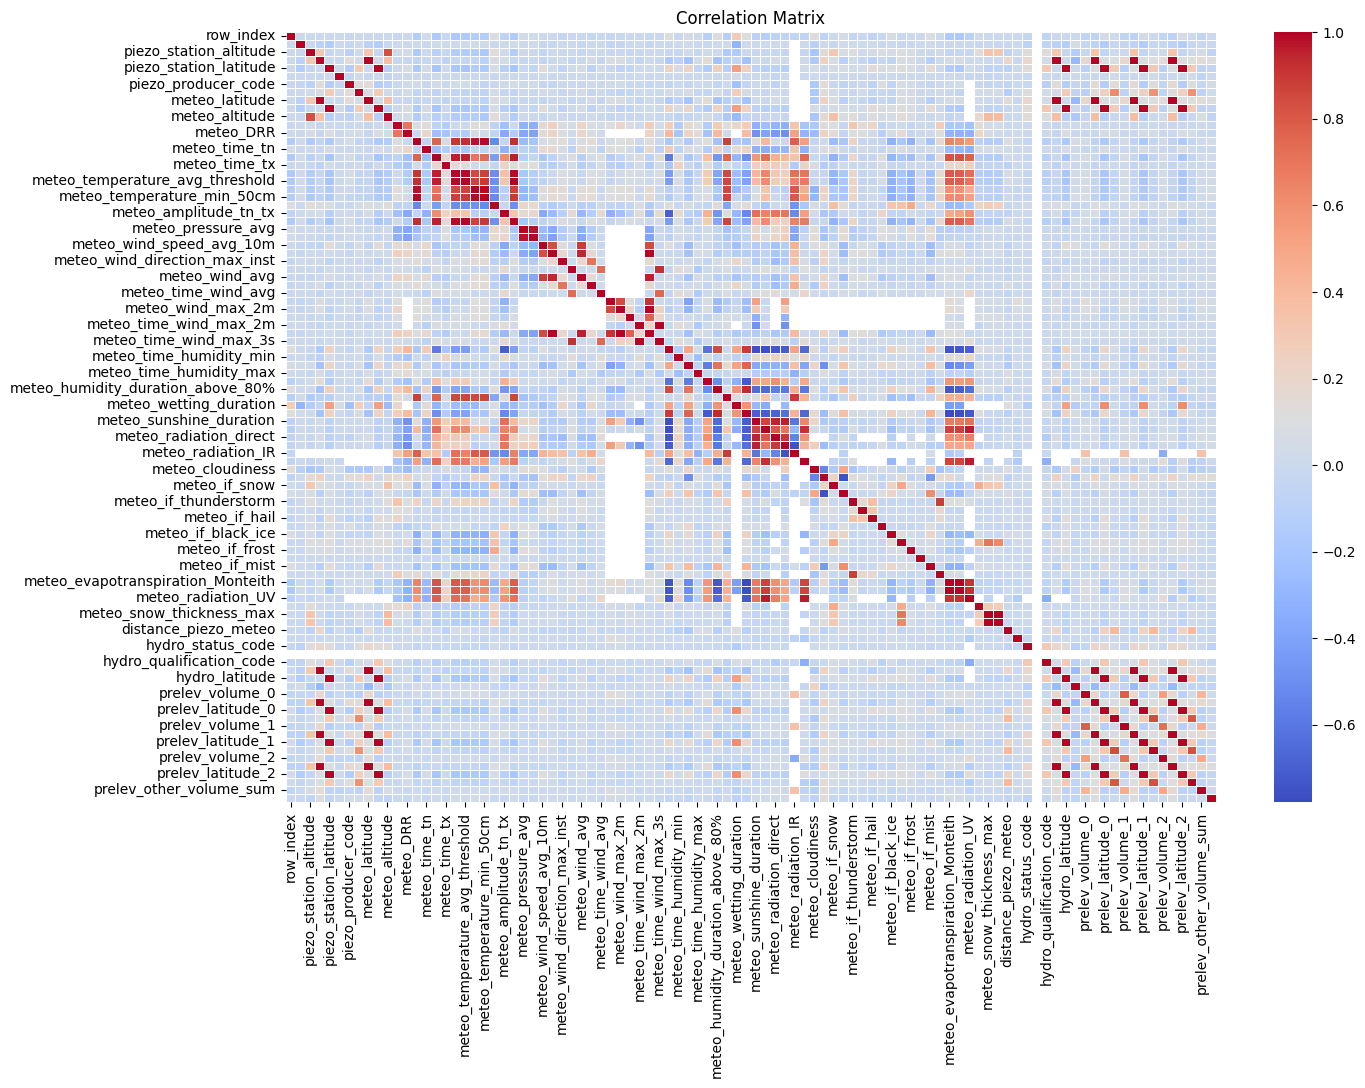

In [5]:
import seaborn as sns

# Correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(x_train[numeric_cols].corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

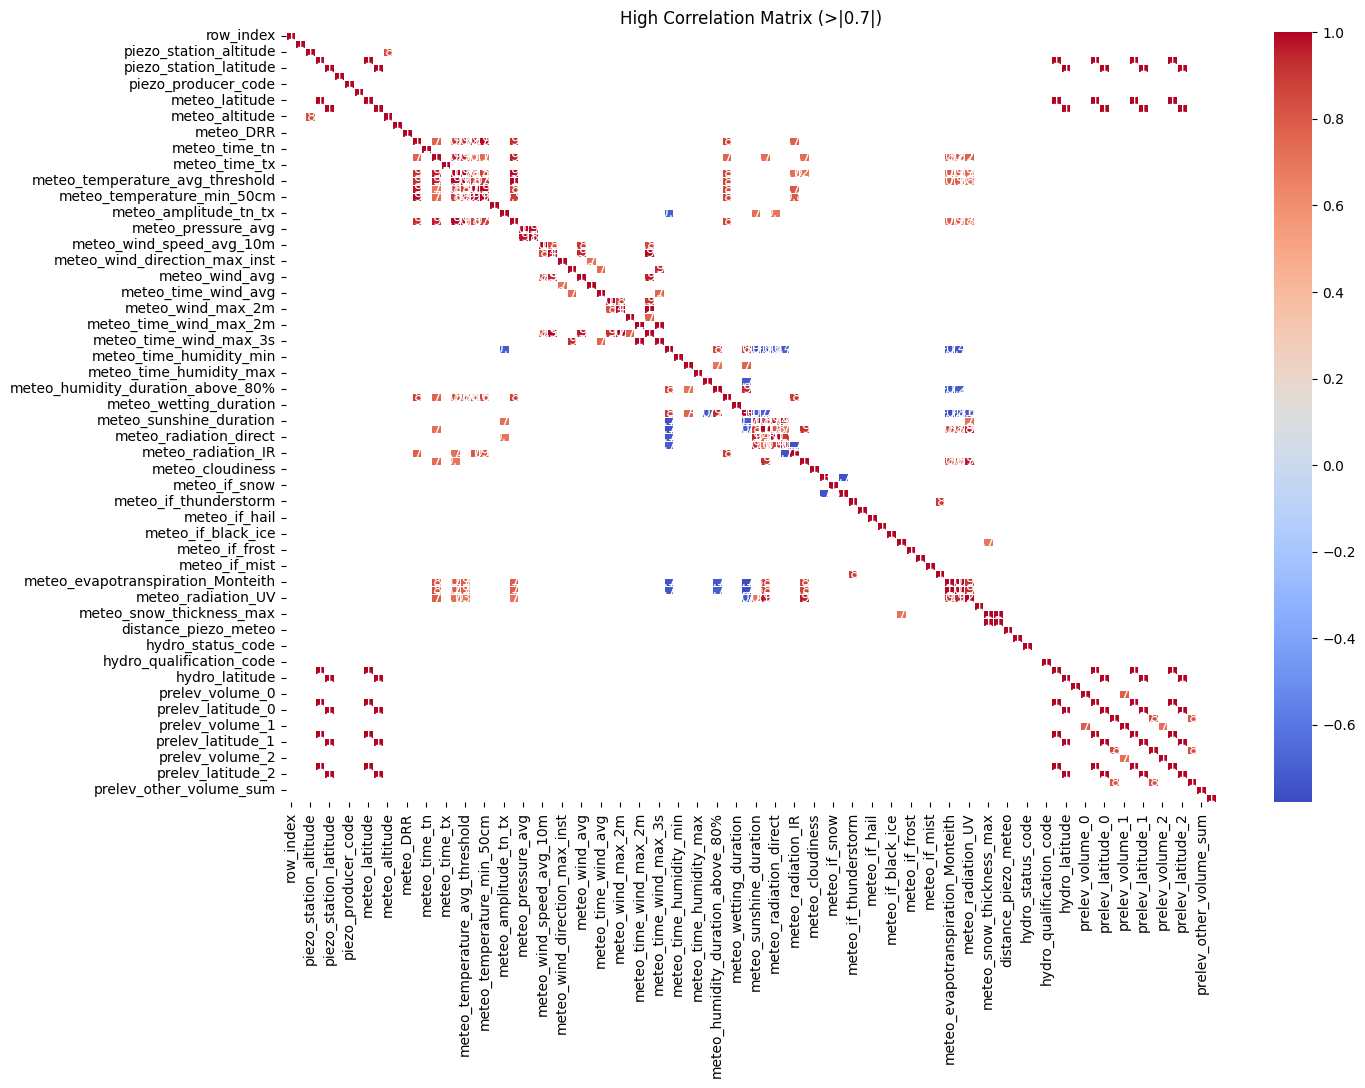

In [4]:
# Filter correlations above 0.7 or below -0.7
corr_matrix = x_train[numeric_cols].corr()
high_corr = corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.7)]

plt.figure(figsize=(15, 10))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', linewidths=0.5, mask=high_corr.isnull())
plt.title("High Correlation Matrix (>|0.7|)")
plt.show()

In [5]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(x_train['piezo_groundwater_level_category'])


# Random Forest to estimate feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train.dropna().select_dtypes(include=['number']), y_train)

# Display feature importance
feature_importance = pd.DataFrame({
    'Feature': numeric_cols,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

ValueError: Found array with 0 sample(s) (shape=(0, 96)) while a minimum of 1 is required by RandomForestClassifier.

In [5]:

subset_columns = ['piezo_groundwater_level_category']  # replace with actual column names
x_train[subset_columns].hist(bins=30, figsize=(15, 5))

plt.tight_layout()
plt.show()

ValueError: hist method requires numerical or datetime columns, nothing to plot.

In [ ]:
# Boxplot to detect outliers
plt.figure(figsize=(10, 8))
sns.boxplot(data=x_train)
plt.show()